## 1. 환경 설정 및 임포트

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

# 프로젝트 루트 경로 추가
project_root = Path.cwd().parent.parent
src_path = project_root / "src"

# sys.path에 추가
for path in [str(project_root), str(src_path)]:
    if path not in sys.path:
        sys.path.insert(0, path)
        logger.debug(f"path: {path}")

logger.debug(f"프로젝트 루트: {project_root}")
logger.debug(f"소스 경로: {src_path}")

# 환경 변수 로드
env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    logger.debug(f"환경 변수 로드: {env_path}")
else:
    logger.warning(f".env 파일을 찾을 수 없습니다 ({env_path})")

2026-01-17 17:50:07 D [ipykernel_launcher:18] - 프로젝트 루트: /home/spai0433/codeit-ai-3team-ad-content
2026-01-17 17:50:07 D [ipykernel_launcher:19] - 소스 경로: /home/spai0433/codeit-ai-3team-ad-content/src
2026-01-17 17:50:07 D [ipykernel_launcher:25] - 환경 변수 로드: /home/spai0433/codeit-ai-3team-ad-content/.env
2026-01-17 17:50:07 D [ipykernel_launcher:19] - 소스 경로: /home/spai0433/codeit-ai-3team-ad-content/src
2026-01-17 17:50:07 D [ipykernel_launcher:25] - 환경 변수 로드: /home/spai0433/codeit-ai-3team-ad-content/.env


## 2. OpenAI API 키 확인

In [19]:
# OpenAI API 키 확인
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    logger.error("OPENAI_API_KEY 환경 변수가 설정되지 않았습니다.")
    logger.error("   .env 파일에 다음을 추가하세요:")
    logger.error("   OPENAI_API_KEY=sk-...")
    raise ValueError("OPENAI_API_KEY가 설정되지 않았습니다")
else:
    logger.debug(f"OpenAI API 키 확인됨 (길이: {len(openai_api_key)} 문자)")
    logger.debug(f"   키 prefix: {openai_api_key[:5]} --- {openai_api_key[-5:]}")

2026-01-17 17:50:07 D [ipykernel_launcher:10] - OpenAI API 키 확인됨 (길이: 164 문자)
2026-01-17 17:50:07 D [ipykernel_launcher:11] -    키 prefix: sk-pr --- cxzEA
2026-01-17 17:50:07 D [ipykernel_launcher:11] -    키 prefix: sk-pr --- cxzEA


## 3. LLMTexttoHTML 클래스 정의

In [20]:
import base64
import io
import re
import tempfile
from pathlib import Path
from typing import Optional, Union

from PIL import Image
from playwright.async_api import async_playwright
from openai import OpenAI


class LLMTexttoHTML:
    """
    OpenAI Vision API와 Playwright를 사용한 LLM 기반 HTML 광고 생성기
    
    이미지와 광고 문구를 입력받아 LLM이 HTML 광고 템플릿을 생성하고,
    Playwright로 실제 이미지로 렌더링합니다.
    
    특징:
    - JPEG 압축으로 LLM 입력 토큰 최적화 (70-90% 절감)
    - gpt-5-mini 모델 지원 (128K 출력 토큰)
    - 비동기 Playwright로 HTML 렌더링
    - 완전한 HTML 생성 보장 (finish_reason 검증)
    """
    
    def __init__(
        self,
        api_key: str,
        model: str = "gpt-5-mini",
        temperature: float = 1.0,
        max_completion_tokens: int = 16000,
    ):
        """
        LLMTexttoHTML 초기화
        
        Args:
            api_key: OpenAI API 키
            model: 사용할 모델 (기본값: gpt-5-mini, 128K 출력 지원)
            temperature: 생성 다양성 (0.0-2.0, 기본값: 0.7)
            max_completion_tokens: 최대 출력 토큰 (기본값: 16000)
        """
        self.openai_client = OpenAI(api_key=api_key)
        self.model = model
        self.temperature = temperature
        self.max_completion_tokens = max_completion_tokens
        
        logger.info(f"LLMTexttoHTML 초기화: model={model}, max_tokens={max_completion_tokens}")
    
    def _image_to_base64_jpeg(
        self,
        image_path: str,
        max_size: int = 1024,
        quality: int = 95,
    ) -> str:
        """
        이미지를 JPEG로 변환 후 Base64 인코딩 (LLM 토큰 효율 최적화)
        
        PNG는 무손실이지만 파일 크기가 크고, LLM은 압축된 JPEG도 잘 이해합니다.
        1024px 썸네일 + quality 95 설정으로 70-90% 크기 절감
        
        Args:
            image_path: 입력 이미지 경로
            max_size: 최대 너비/높이 (기본값: 1024px)
            quality: JPEG 품질 (1-100, 기본값: 95)
            
        Returns:
            Base64 인코딩된 JPEG 문자열
        """
        img = Image.open(image_path)
        
        # 비율 유지하며 리사이즈
        img.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)
        
        # RGBA나 P 모드는 RGB로 변환 (JPEG는 투명도 미지원)
        if img.mode in ("RGBA", "P", "LA"):
            # 흰색 배경 생성
            background = Image.new("RGB", img.size, (255, 255, 255))
            if img.mode == "RGBA" or img.mode == "LA":
                background.paste(img, mask=img.split()[-1])  # 알파 채널 사용
            else:
                background.paste(img)
            img = background
        elif img.mode != "RGB":
            img = img.convert("RGB")
        
        # JPEG로 압축
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality, optimize=True)
        encoded = base64.b64encode(buffer.getvalue()).decode("utf-8")
        
        original_size = Path(image_path).stat().st_size
        compressed_size = len(buffer.getvalue())
        logger.info(f"이미지 압축: {original_size:,}B → {compressed_size:,}B ({compressed_size/original_size*100:.1f}%)")
        
        return encoded
    
    def generate_html(
        self,
        image_path: str,
        ad_text: str,
        style_hint: Optional[str] = None,
    ) -> str:
        """
        이미지와 광고 문구를 분석하여 HTML 광고 템플릿 생성
        
        Args:
            image_path: 분석할 이미지 경로
            ad_text: 광고 문구 (예: "특가세일 2500원")
            style_hint: 스타일 힌트 (예: "modern", "elegant", "energetic")
            
        Returns:
            생성된 HTML 문자열 (Base64 이미지 포함)
        """
        logger.info(f"HTML 생성 시작: image={image_path}, text={ad_text}")
        
        # 이미지를 JPEG로 변환 및 Base64 인코딩 (LLM 효율 최적화)
        image_b64 = self._image_to_base64_jpeg(image_path)
        
        # 프롬프트 구성
        system_prompt = f"""당신은 전문 HTML 광고 디자이너입니다.
이미지를 분석하여 이미지와 어울리는 완전한 광고 HTML을 생성합니다.

[핵심 요구사항]
- 반드시 완전한 HTML 문서를 생성 (<!DOCTYPE html>부터 </html>까지)
- 인라인 CSS 스타일 포함
- 반응형 디자인 (width: 1024px, height:1024px)
- 제공된 jpg Base64 이미지는 html 제작을 위한 분석용으로 사용
- {image_path} 배경 이미지로 사용
- 이미지는 비율유지 full cover
- 텍스트 오버레이로 광고 문구 배치
- 깔끔한 타이포그래피와 적절한 여백
- 그라디언트나 그림자로 가독성 향상
- JavaScript 사용하지 않음

[중요]
- HTML을 끝까지 완성해야 합니다
- </html> 태그로 반드시 종료
- 중간에 생략하지 말 것"""

        user_prompt = f"""이미지를 분석하여 다음 광고 문구가 포함된 완전한 HTML을 생성해주세요:

광고 문구: "{ad_text}"
{f'스타일 힌트: {style_hint}' if style_hint else ''}

요구사항:
- 이미지의 주요 색상과 분위기를 파악하여 조화로운 디자인
- 광고 문구 레이어 투명
- 광고 문구를 눈에 띄게 배치
- 텍스트 크기와 색상은 배경과 대비되도록 설정
- {image_path} 백그라운드로 사용
- 백그라운드 크기 고정 width: 1024px, height:1024px

출력 형식:
- 완성된 HTML 코드만 출력 (설명 없이)
- 반드시 <!DOCTYPE html>부터 </html>까지 전체 코드 출력
- 코드 블록 마크다운(```) 사용하지 말고 순수 HTML만 출력"""

        messages = [
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_b64}",
                            "detail": "high"
                        },
                    },
                ],
            },
        ]
        
        # OpenAI API 호출
        logger.debug(f"OpenAI API 호출 시작: model={self.model}, max_tokens={self.max_completion_tokens}")
        response = self.openai_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.temperature,
            max_completion_tokens=self.max_completion_tokens,
        )
        
        html_output = response.choices[0].message.content
        finish_reason = response.choices[0].finish_reason
        
        logger.debug(f"API 응답 완료: finish_reason={finish_reason}, 토큰 사용={response.usage.total_tokens}")
        
        if not html_output:
            logger.error("OpenAI API가 빈 응답을 반환했습니다")
            raise ValueError("HTML 생성 실패: 빈 응답")
        
        # finish_reason이 length인 경우 경고
        if finish_reason == "length":
            logger.warning("HTML이 max_completion_tokens 제한으로 잘렸을 수 있습니다")
            logger.warning(f"현재 max_completion_tokens={self.max_completion_tokens}, 사용된 토큰={response.usage.completion_tokens}")
        
        logger.info(f"HTML 생성 완료: {len(html_output)} 문자, finish_reason={finish_reason}")
        
        # HTML 코드 블록 제거 (```html ... ``` 형식인 경우)
        if "```" in html_output:
            parts = html_output.split("```")
            for i, part in enumerate(parts):
                if part.strip().startswith("html"):
                    html_output = part[4:].strip()
                    break
                elif i % 2 == 1:  # 홀수 인덱스는 코드 블록 내부
                    html_output = part.strip()
                    break
        
        # HTML 유효성 간단 체크
        html_lower = html_output.lower()
        if not html_lower.startswith("<!doctype html") and not html_lower.startswith("<html"):
            logger.warning("HTML이 올바른 형식으로 시작하지 않습니다")
        
        if "</html>" not in html_lower:
            logger.warning("HTML이 </html> 태그로 종료되지 않았습니다 (잘렸을 가능성)")
        
        return html_output
    
    def generate_prompt_html(
        self,
        image_path: str,
        ad_text: str,
        text_prompt: Optional[str] = None,
        composition_prompt: Optional[str] = None,
    ) -> str:
        """
        이미지와 광고 문구를 분석하여 HTML 광고 템플릿 생성
        
        Args:
            image_path: 분석할 이미지 경로
            ad_text: 광고 문구 (예: "특가세일 2500원")
            style_hint: 스타일 힌트 (예: "modern", "elegant", "energetic")
            
        Returns:
            생성된 HTML 문자열 (Base64 이미지 포함)
        """
        logger.info(f"HTML 생성 시작: image={image_path}, text={ad_text}")
        
        # 이미지를 JPEG로 변환 및 Base64 인코딩 (LLM 효율 최적화)
        image_b64 = self._image_to_base64_jpeg(image_path)
        
        # 프롬프트 구성
        system_prompt = f"""당신은 전문 HTML 광고 디자이너입니다.
이미지를 분석하여 이미지와 어울리는 완전한 광고 HTML을 생성합니다.

[핵심 요구사항]
- 반드시 완전한 HTML 문서를 생성 (<!DOCTYPE html>부터 </html>까지)
- 인라인 CSS 스타일 포함
- 반응형 디자인 (width: 1024px, height:1024px)
- 제공된 jpg Base64 이미지는 html 제작을 위한 분석용으로 사용
- {image_path} 배경 이미지로 사용
- 이미지는 비율유지 full cover
- 텍스트 오버레이로 광고 문구 배치
- 깔끔한 타이포그래피와 적절한 여백
- 그라디언트나 그림자로 가독성 향상
- JavaScript 사용하지 않음

[중요]
- HTML을 끝까지 완성해야 합니다
- </html> 태그로 반드시 종료
- 중간에 생략하지 말 것"""

        user_prompt = f"""이미지를 분석하여 다음 광고 문구가 포함된 완전한 HTML을 생성해주세요:

광고 문구: "{ad_text}"
{f'텍스트 프롬프트: {text_prompt}' if text_prompt else ''}
{f'구성 프롬프트: {composition_prompt}' if composition_prompt else ''}

요구사항:
- 이미지의 주요 색상과 분위기를 파악하여 조화로운 디자인
- 광고 문구 레이어 투명
- 광고 문구를 눈에 띄게 배치
- 텍스트 크기와 색상은 배경과 대비되도록 설정
- {image_path} 백그라운드로 사용
- 백그라운드 크기 고정 width: 1024px, height:1024px

출력 형식:
- 완성된 HTML 코드만 출력 (설명 없이)
- 반드시 <!DOCTYPE html>부터 </html>까지 전체 코드 출력
- 코드 블록 마크다운(```) 사용하지 말고 순수 HTML만 출력"""

        messages = [
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_b64}",
                            "detail": "high"
                        },
                    },
                ],
            },
        ]
        
        # OpenAI API 호출
        logger.debug(f"OpenAI API 호출 시작: model={self.model}, max_tokens={self.max_completion_tokens}")
        response = self.openai_client.chat.completions.create(
            model=self.model,
            messages=messages,
            temperature=self.temperature,
            max_completion_tokens=self.max_completion_tokens,
        )
        
        html_output = response.choices[0].message.content
        finish_reason = response.choices[0].finish_reason
        
        logger.debug(f"API 응답 완료: finish_reason={finish_reason}, 토큰 사용={response.usage.total_tokens}")
        
        if not html_output:
            logger.error("OpenAI API가 빈 응답을 반환했습니다")
            raise ValueError("HTML 생성 실패: 빈 응답")
        
        # finish_reason이 length인 경우 경고
        if finish_reason == "length":
            logger.warning("HTML이 max_completion_tokens 제한으로 잘렸을 수 있습니다")
            logger.warning(f"현재 max_completion_tokens={self.max_completion_tokens}, 사용된 토큰={response.usage.completion_tokens}")
        
        logger.info(f"HTML 생성 완료: {len(html_output)} 문자, finish_reason={finish_reason}")
        
        # HTML 코드 블록 제거 (```html ... ``` 형식인 경우)
        if "```" in html_output:
            parts = html_output.split("```")
            for i, part in enumerate(parts):
                if part.strip().startswith("html"):
                    html_output = part[4:].strip()
                    break
                elif i % 2 == 1:  # 홀수 인덱스는 코드 블록 내부
                    html_output = part.strip()
                    break
        
        # HTML 유효성 간단 체크
        html_lower = html_output.lower()
        if not html_lower.startswith("<!doctype html") and not html_lower.startswith("<html"):
            logger.warning("HTML이 올바른 형식으로 시작하지 않습니다")
        
        if "</html>" not in html_lower:
            logger.warning("HTML이 </html> 태그로 종료되지 않았습니다 (잘렸을 가능성)")
        
        return html_output    
    
    async def render_html_to_image(
        self,
        html_path: str,
        output_path: str,
        width: int = 1024,
        height: int = 1024,
        timeout: int = 30000,
    ) -> str:
        """
        Playwright로 HTML 파일을 이미지로 렌더링 (비동기)
        
        Args:
            html_path: 렌더링할 HTML 파일 경로
            output_path: 출력 이미지 경로
            width: 뷰포트 너비
            height: 뷰포트 높이
            timeout: 배경 이미지 로딩 대기 타임아웃 (밀리초, 기본값: 30000)
            
        Returns:
            저장된 이미지 경로
        """
        logger.info(f"HTML → 이미지 렌더링 시작: html={html_path}, output={output_path}, timeout={timeout}ms")
        
        # HTML 파일을 file:// URL로 변환
        html_file_url = Path(html_path).resolve().as_uri()
        logger.debug(f"HTML 파일 URL: {html_file_url}")
        
        async with async_playwright() as p:
            browser = await p.chromium.launch()
            page = await browser.new_page(viewport={"width": width, "height": height})
            
            # HTML 파일 로드 (file:// 프로토콜로 상대 경로 이미지 자동 해석)
            await page.goto(html_file_url, wait_until="domcontentloaded")
            
            # 배경 이미지 로딩 대기 (networkidle 또는 수동 체크)
            logger.info("배경 이미지 로딩 대기 중...")
            try:
                # 네트워크 유휴 상태까지 대기 (이미지 로드 포함)
                await page.wait_for_load_state("networkidle", timeout=timeout)
                logger.info("네트워크 유휴 상태 도달 (이미지 로드 완료)")
            except Exception as e:
                logger.warning(f"networkidle 타임아웃 ({timeout}ms): {e}")
                logger.info("수동 배경 이미지 로딩 체크 진행...")
            
            # 추가 검증: JavaScript로 배경 이미지 로딩 상태 확인
            try:
                bg_loaded = await page.evaluate("""
                    async () => {
                        const checkBackgroundImage = () => {
                            const elements = document.querySelectorAll('*');
                            const bgElements = [];
                            
                            elements.forEach(el => {
                                const bgImage = window.getComputedStyle(el).backgroundImage;
                                if (bgImage && bgImage !== 'none' && bgImage.includes('url(')) {
                                    bgElements.push({
                                        element: el,
                                        bgImage: bgImage
                                    });
                                }
                            });
                            
                            return bgElements;
                        };
                        
                        // 배경 이미지 요소 찾기
                        const bgElements = checkBackgroundImage();
                        
                        if (bgElements.length === 0) {
                            return { loaded: false, count: 0, message: '배경 이미지 요소 없음' };
                        }
                        
                        // 각 배경 이미지 로딩 대기
                        const loadPromises = bgElements.map(({ element, bgImage }) => {
                            return new Promise((resolve) => {
                                // URL 추출
                                const urlMatch = bgImage.match(/url\\(['"]?([^'"()]+)['"]?\\)/);
                                if (!urlMatch) {
                                    resolve({ success: false, url: bgImage });
                                    return;
                                }
                                
                                const imageUrl = urlMatch[1];
                                
                                // Base64 이미지는 즉시 로드됨
                                if (imageUrl.startsWith('data:')) {
                                    resolve({ success: true, url: 'base64 image' });
                                    return;
                                }
                                
                                // 일반 URL 이미지 프리로드
                                const img = new Image();
                                img.onload = () => resolve({ success: true, url: imageUrl });
                                img.onerror = () => resolve({ success: false, url: imageUrl });
                                img.src = imageUrl;
                            });
                        });
                        
                        const results = await Promise.all(loadPromises);
                        const loadedCount = results.filter(r => r.success).length;
                        
                        return {
                            loaded: loadedCount > 0,
                            count: bgElements.length,
                            loadedCount: loadedCount,
                            results: results
                        };
                    }
                """)
                
                if bg_loaded['loaded']:
                    logger.info(f"배경 이미지 로딩 완료: {bg_loaded['loadedCount']}/{bg_loaded['count']}개")
                    for idx, result in enumerate(bg_loaded.get('results', [])[:3]):
                        status = "✓" if result['success'] else "✗"
                        url_display = result['url'][:60] if len(result['url']) > 60 else result['url']
                        logger.debug(f"  {status} 이미지 {idx+1}: {url_display}...")
                else:
                    logger.warning(f"배경 이미지 로딩 실패: {bg_loaded.get('message', '알 수 없는 오류')}")
                    
            except Exception as e:
                logger.error(f"배경 이미지 로딩 확인 중 오류: {e}")
            
            # 추가 렌더링 대기
            await page.wait_for_timeout(1000)
            
            # 스크린샷
            await page.screenshot(path=output_path, full_page=True)
            
            await browser.close()
        
        logger.info(f"이미지 렌더링 완료: {output_path}")
        return output_path

    async def generate_prompt_png(
        self,
        image: Union[Image.Image, str],
        ad_text: str,
        text_prompt: Optional[str] = None,
        composition_prompt: Optional[str] = None,
    ) -> Image.Image:
        """
        이미지와 광고 문구를 분석하여 PNG 광고 이미지 생성
        
        Args:
            image: PIL Image 객체 또는 이미지 경로
            ad_text: 광고 문구
            text_prompt: 텍스트 프롬프트
            composition_prompt: 구성 프롬프트
            
        Returns:
            생성된 PIL Image 객체
        """
        temp_image_path = None
        temp_html_path = None
        temp_output_path = None
        
        try:
            # 임시 디렉토리 생성
            temp_dir = Path(tempfile.mkdtemp(prefix="llm_html_"))
            logger.debug(f"임시 디렉토리 생성: {temp_dir}")
            
            # PIL Image 객체인 경우 임시 파일로 저장
            if isinstance(image, Image.Image):
                temp_image_path = temp_dir / "input_image.png"
                image.save(temp_image_path)
                logger.debug(f"PIL Image를 임시 파일로 저장: {temp_image_path}")
                image_path = str(temp_image_path)
            else:
                # 문자열 경로인 경우 그대로 사용
                image_path = image
                logger.debug(f"이미지 경로 사용: {image_path}")
            
            # 임시 HTML 및 출력 경로 설정
            temp_html_path = temp_dir / "temp.html"
            temp_output_path = temp_dir / "output.png"
            
            # HTML 생성
            html_output = self.generate_prompt_html(
                image_path=image_path,
                ad_text=ad_text,
                text_prompt=text_prompt,
                composition_prompt=composition_prompt
            )
            
            # HTML 저장
            logger.info("생성된 HTML 저장 중...")
            with open(temp_html_path, "w", encoding="utf-8") as f:
                f.write(html_output)
            logger.debug(f"임시 HTML 저장: {temp_html_path}")
            
            # HTML → 이미지 렌더링
            await self.render_html_to_image(
                html_path=str(temp_html_path),
                output_path=str(temp_output_path),
                width=1024,
                height=1024
            )
            
            # 결과 이미지 로드
            result_image = Image.open(temp_output_path)
            # 메모리로 복사 (파일 핸들 해제를 위해)
            result_image.load()
            
            logger.info("PNG 광고 이미지 생성 완료")
            return result_image
            
        finally:
            # 임시 파일 정리
            import shutil
            if temp_dir and temp_dir.exists():
                try:
                    shutil.rmtree(temp_dir)
                    logger.debug(f"임시 디렉토리 삭제: {temp_dir}")
                except Exception as e:
                    logger.warning(f"임시 디렉토리 삭제 실패: {e}")

logger.info("LLMTexttoHTML 클래스 정의 완료")


2026-01-17 17:50:07 I [ipykernel_launcher:564] - LLMTexttoHTML 클래스 정의 완료


## 4. 사용 예제

2026-01-17 17:51:59 I [ipykernel_launcher:48] - LLMTexttoHTML 초기화: model=gpt-5-mini, max_tokens=16000
2026-01-17 17:51:59 D [ipykernel_launcher:507] - 임시 디렉토리 생성: /tmp/llm_html_eaniom4a
2026-01-17 17:51:59 D [ipykernel_launcher:507] - 임시 디렉토리 생성: /tmp/llm_html_eaniom4a


2026-01-17 17:52:00 D [ipykernel_launcher:513] - PIL Image를 임시 파일로 저장: /tmp/llm_html_eaniom4a/input_image.png
2026-01-17 17:52:00 I [ipykernel_launcher:240] - HTML 생성 시작: image=/tmp/llm_html_eaniom4a/input_image.png, text=특가세일 2500
2026-01-17 17:52:00 I [ipykernel_launcher:240] - HTML 생성 시작: image=/tmp/llm_html_eaniom4a/input_image.png, text=특가세일 2500
2026-01-17 17:52:00 I [ipykernel_launcher:94] - 이미지 압축: 979,631B → 185,504B (18.9%)
2026-01-17 17:52:00 D [ipykernel_launcher:303] - OpenAI API 호출 시작: model=gpt-5-mini, max_tokens=16000
2026-01-17 17:52:00 I [ipykernel_launcher:94] - 이미지 압축: 979,631B → 185,504B (18.9%)
2026-01-17 17:52:00 D [ipykernel_launcher:303] - OpenAI API 호출 시작: model=gpt-5-mini, max_tokens=16000


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


2026-01-17 17:52:42 D [ipykernel_launcher:314] - API 응답 완료: finish_reason=stop, 토큰 사용=4385
2026-01-17 17:52:42 I [ipykernel_launcher:325] - HTML 생성 완료: 4114 문자, finish_reason=stop
2026-01-17 17:52:42 I [ipykernel_launcher:533] - 생성된 HTML 저장 중...
2026-01-17 17:52:42 D [ipykernel_launcher:536] - 임시 HTML 저장: /tmp/llm_html_eaniom4a/temp.html
2026-01-17 17:52:42 I [ipykernel_launcher:369] - HTML → 이미지 렌더링 시작: html=/tmp/llm_html_eaniom4a/temp.html, output=/tmp/llm_html_eaniom4a/output.png, timeout=30000ms
2026-01-17 17:52:42 D [ipykernel_launcher:373] - HTML 파일 URL: file:///tmp/llm_html_eaniom4a/temp.html
2026-01-17 17:52:42 I [ipykernel_launcher:325] - HTML 생성 완료: 4114 문자, finish_reason=stop
2026-01-17 17:52:42 I [ipykernel_launcher:533] - 생성된 HTML 저장 중...
2026-01-17 17:52:42 D [ipykernel_launcher:536] - 임시 HTML 저장: /tmp/llm_html_eaniom4a/temp.html
2026-01-17 17:52:42 I [ipykernel_launcher:369] - HTML → 이미지 렌더링 시작: html=/tmp/llm_html_eaniom4a/temp.html, output=/tmp/llm_html_eaniom4a/output.

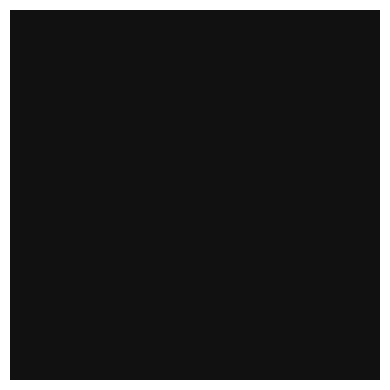

In [22]:
from helper_plot_hangul import matplotlib_font_reset
import matplotlib.pyplot as plt

# 테스트용 이미지 경로 및 출력 디렉토리 설정
test_image_path = "result_image.png"
test_image = Image.open(test_image_path)

generator = LLMTexttoHTML(openai_api_key)

text_prompt = "3D render of gold foil balloon text, inflated letters, shiny metallic reflective texture, smooth surface, floating in air, studio lighting, sharp details, high quality, isolated on black background"
composition_prompt = "with subtle shadow, glowing effect, integrated with lighting"

result = await generator.generate_prompt_png(test_image, "특가세일 2500",text_prompt=text_prompt, composition_prompt=composition_prompt)

plt.figure(figsize=(4,4))
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()